# Data Gathering

## Japan

| Website        | Dataset(s)                                                                                                                      | URL                                                            | Remarks                                                                              |
|----------------|---------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------|--------------------------------------------------------------------------------------|
| Japanese Power | • Day-ahead Prices - 2010-present, 30m <br/> • Overall load/demand - 2016-present, 30m. <br/> • Temperature - 1995-present, 1D. | https://japanesepower.org/index.html                           |                                                                                      | 
| Renewable EI   | • Load/demand by generation source, 2016-2024/06, 1h.                                                                           | https://www.renewable-ei.org/en/statistics/electricity/#demand | Use Chrome devtools network tab to inspect underlying API and call, then parse JSON. |


## Australia

| Website      | Dataset(s)                                                                                           | URL                                                                                      | Remarks                                                                                                |
|--------------|------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------|
| AEMO         | • Spot Prices / Load - 1998 present, 5m. <br/> • Fuel mix - 2023 Oct-present, 1W (weekly frequency). | https://aemo.com.au/energy-systems/electricity/national-electricity-market-nem/data-nem  | For price data, need to do the same trick to inspect the API call as you select, e.g NSW 2024 January. | 


In [57]:
import requests
import pandas as pd

def fetch_and_process_data(year):

    url = f"https://www.renewable-ei.org/en/statistics/electricity/data/{year}/power-data.json"
    response = requests.get(url)
    data = response.json()
    df = pd.json_normalize(data)

    substrings = [
        'epochs',
        'nuclear', 'thermal', 'hydropower', 'geothermal', 'bioenergy', 'solar', 'wind',
        'pumping_up', 'pumping_down', 'regional_in', 'regional_out', 'solar_curtailment', 
        'wind_curtailment'
    ]

    pattern = '|'.join(substrings)
    df = df.loc[:, df.columns.str.contains(pattern)]

    df = df.explode(df.columns.tolist())
    df = df.convert_dtypes()  # Adjust types for each column
    df['epochs'] = pd.to_datetime(df['epochs'], unit='s')  # Convert epochs to datetime
    
    print(f"Processed data for year {year}")
    return df

all_data = pd.DataFrame()

for year in range(2016, 2025):
    yearly_data = fetch_and_process_data(year)
    all_data = pd.concat([all_data, yearly_data], ignore_index=True)

all_data = all_data.drop_duplicates()

all_data.to_pickle('JEPX_Fuel_Mix.pkl')
all_data.to_parquet('JEPX_Fuel_Mix.parquet')

print("Data saved as 'JEPX_Fuel_Mix.pkl' and 'JEPX_Fuel_Mix.parquet'")


Processed data for year 2016
Processed data for year 2017
Processed data for year 2018
Processed data for year 2019
Processed data for year 2020
Processed data for year 2021
Processed data for year 2022
Processed data for year 2023
Data saved as 'JEPX_Fuel_Mix.pkl' and 'JEPX_Fuel_Mix.parquet'


In [86]:
import requests
import pandas as pd
import concurrent.futures
import time
import random
from io import StringIO

years = range(2015, 2025)
months = [f"{month:02d}" for month in range(1, 13)]
regions = ["NSW1", "QLD1", "VIC1", "SA1", "TAS1"]

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36"
}
dataframes = []

def fetch_data(year, month, region):
    base_url = f"https://aemo.com.au/aemo/data/nem/priceanddemand/PRICE_AND_DEMAND_{year}{month}_{region}.csv"

    time.sleep(random.uniform(0.1, 0.5))  
    
    try:
        response = requests.get(base_url, headers=headers)
        response.raise_for_status()  
        data = StringIO(response.text)
        df = pd.read_csv(data)
        df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'], format='%Y/%m/%d %H:%M:%S')
        df = df.drop(columns=['PERIODTYPE'])
        
        print(f"Fetched data for {year}-{month} in {region}")
        return df
    
    except requests.exceptions.RequestException as e:
        print(f"Failed to fetch data for {year}-{month} in {region}: {e}")
        return None

with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    futures = []
    for year in years:
        for month in months:
            for region in regions:
                futures.append(executor.submit(fetch_data, year, month, region))
                time.sleep(random.uniform(0.5, 3.0))  # Random sleep between 0.5 and 2 seconds
    
    for future in concurrent.futures.as_completed(futures):
        df = future.result()
        if df is not None:
            dataframes.append(df)

nem_df = pd.concat(dataframes, ignore_index=True).sort_values(['REGION','SETTLEMENTDATE'])

nem_df.to_parquet('NEM_Spot.parquet')


Fetched data for 2015-01 in NSW1
Fetched data for 2015-01 in QLD1
Fetched data for 2015-01 in VIC1
Fetched data for 2015-01 in SA1
Fetched data for 2015-01 in TAS1
Fetched data for 2015-02 in NSW1
Fetched data for 2015-02 in QLD1
Fetched data for 2015-02 in VIC1
Fetched data for 2015-02 in SA1
Fetched data for 2015-02 in TAS1
Fetched data for 2015-03 in NSW1
Fetched data for 2015-03 in QLD1
Fetched data for 2015-03 in VIC1
Fetched data for 2015-03 in SA1
Fetched data for 2015-03 in TAS1
Fetched data for 2015-04 in NSW1
Fetched data for 2015-04 in QLD1
Fetched data for 2015-04 in VIC1
Fetched data for 2015-04 in SA1
Fetched data for 2015-04 in TAS1
Fetched data for 2015-05 in NSW1
Fetched data for 2015-05 in QLD1
Fetched data for 2015-05 in VIC1
Fetched data for 2015-05 in SA1
Fetched data for 2015-05 in TAS1
Fetched data for 2015-06 in NSW1
Fetched data for 2015-06 in QLD1
Fetched data for 2015-06 in VIC1
Fetched data for 2015-06 in SA1
Fetched data for 2015-06 in TAS1
Fetched data for

# Exploration

## JPN

In [1]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import polars.selectors as cs

sns.set_style('darkgrid')
plt.style.use("dark_background") 


jpn_spot = pd.read_csv('JEPX Spot (30m, 2010-2024).csv', parse_dates=True).set_index('datetime')
jpn_spot.index = pd.to_datetime(jpn_spot.index)
jpn_mix = pd.read_parquet('JEPX_Fuel_Mix.parquet').set_index('epochs')

weather = pd.read_csv('JEPX Weather (1D, 1995-2024).csv')
weather.set_index('DateTime', inplace=True)
weather.index = pd.to_datetime(weather.index)

### System Price Over Time

Text(0.0, 1.0, 'Japanese Intraday System Price (Maximum price per day), Yen/kWh, 2010-2024 \n - Price spike on December 2021: Colder winter, lockdown (high demand), expensive JKM LNG')

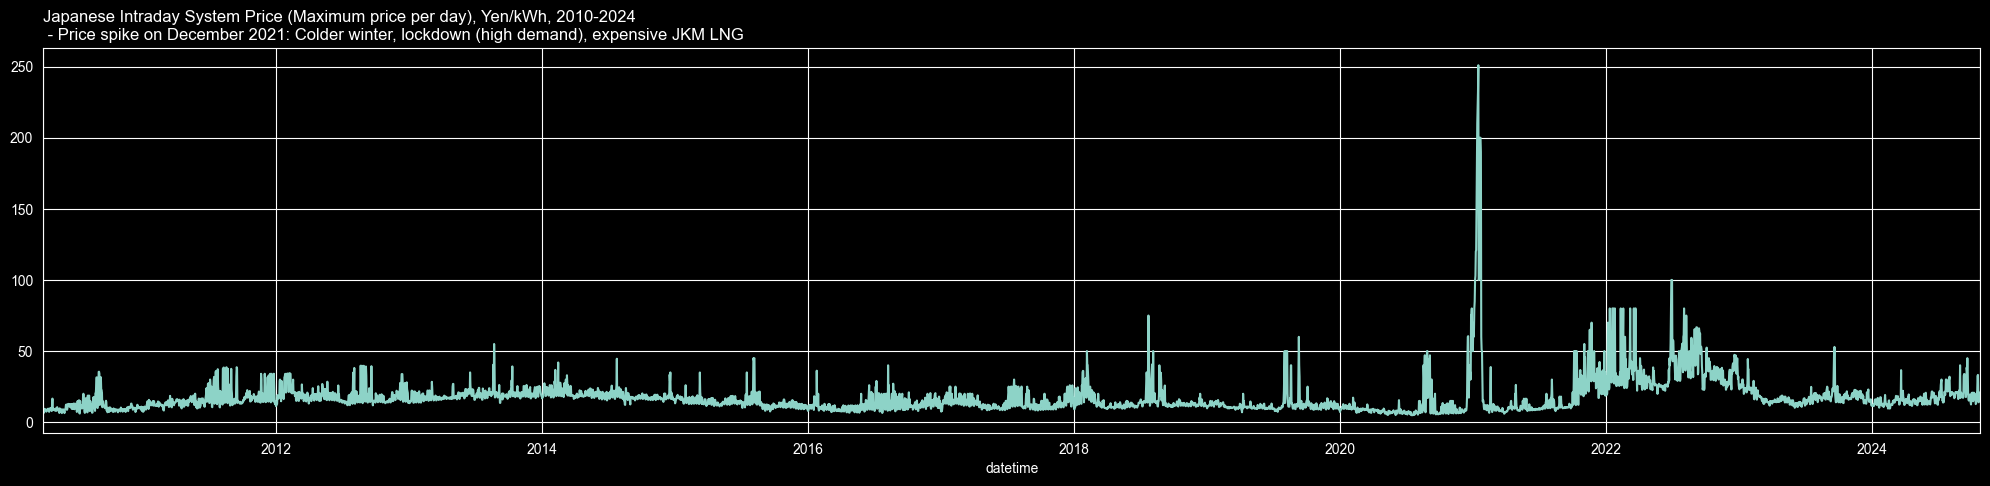

In [177]:
ax = jpn_spot['System Price Yen/kWh'].resample('D').max().plot(figsize=(25,5))

ax.set_title("""Japanese Intraday System Price (Maximum price per day), Yen/kWh, 2010-2024 \n - Price spike on December 2021: Colder winter, lockdown (high demand), expensive JKM LNG (?) """, loc='left')

Text(0.0, 1.0, 'Why increased vol during Sep-2021 to 2023? \n Cold winter + Russia-Ukraine war = very volatile and high JKM')

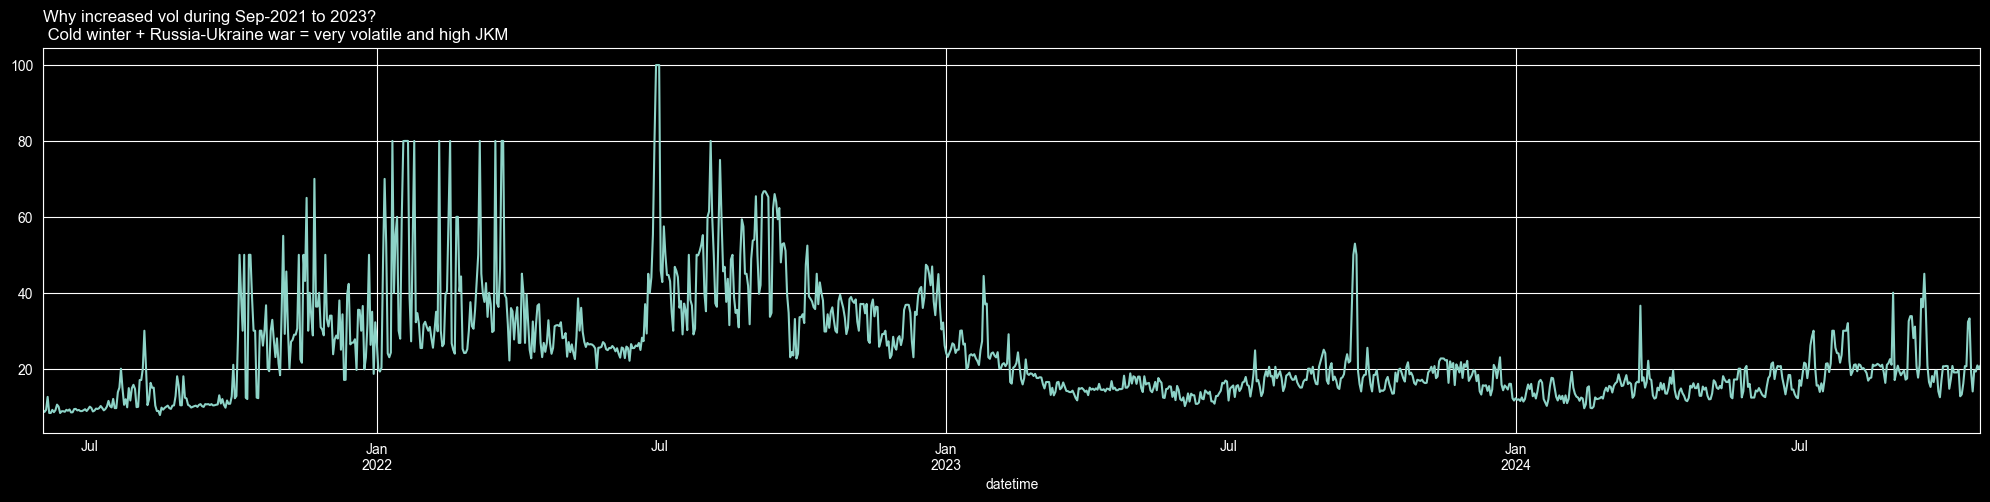

In [229]:

ax = jpn_spot['System Price Yen/kWh'].loc['2021-06':].resample('D').max().plot(figsize=(25,5))

ax.set_title("""Why increased vol during Sep-2021 to 2023? \n Cold winter + Russia-Ukraine war = very volatile and high JKM""", loc='left')

Text(0.0, 1.0, 'Mean temperature across grids 2018-2024 from Japanesepower.com \n1. Can see very warm winter in 2024, explaining low prices and decreased contracted volume below? \n2. Interesting to see a few degrees can make such a large difference in demand.')

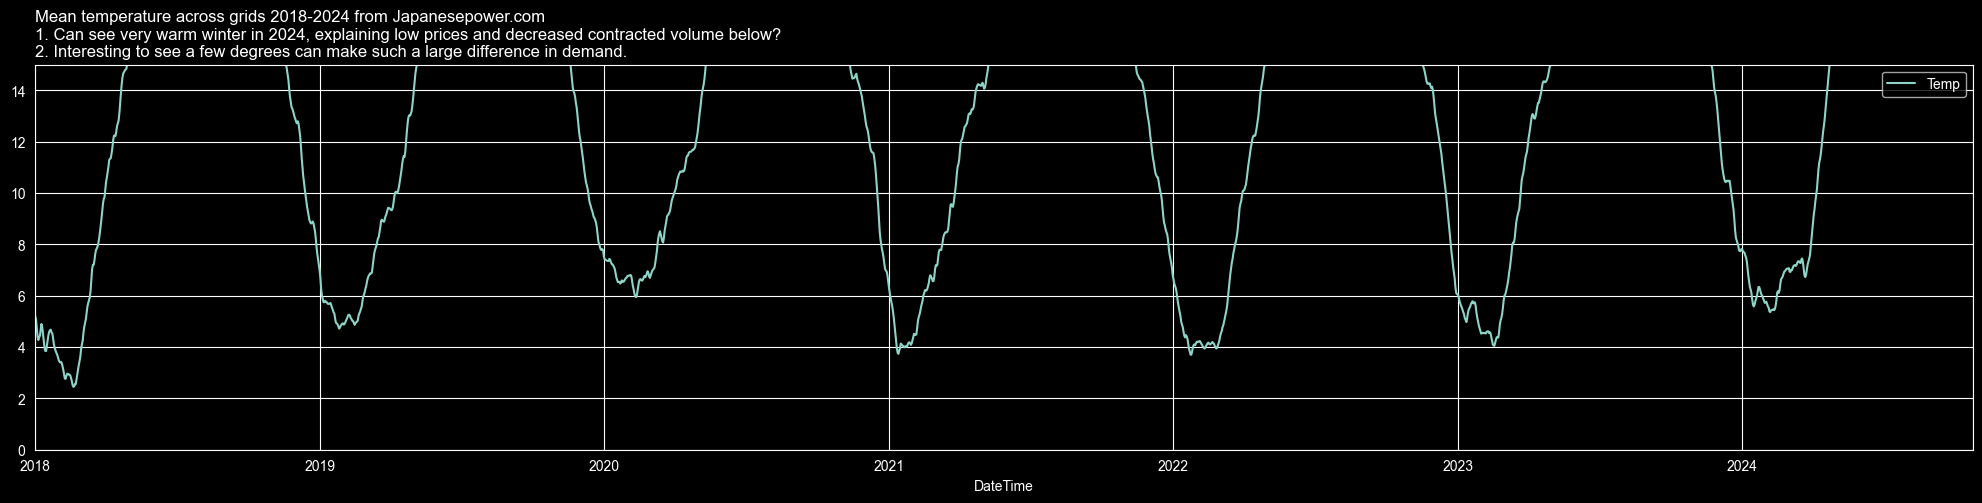

In [38]:

temps = weather.mean(axis=1).to_frame('Temp').loc['2018':].rolling('30D').mean()
ax = temps.plot(figsize=(25,5),ylim=(0,15))

ax.set_title("""Mean temperature across grids 2018-2024 from Japanesepower.com \n1. Can see very warm winter in 2024, explaining low prices and decreased contracted volume below? \n2. Interesting to see a few degrees can make such a large difference in demand.""", loc='left')



<Axes: xlabel='datetime'>

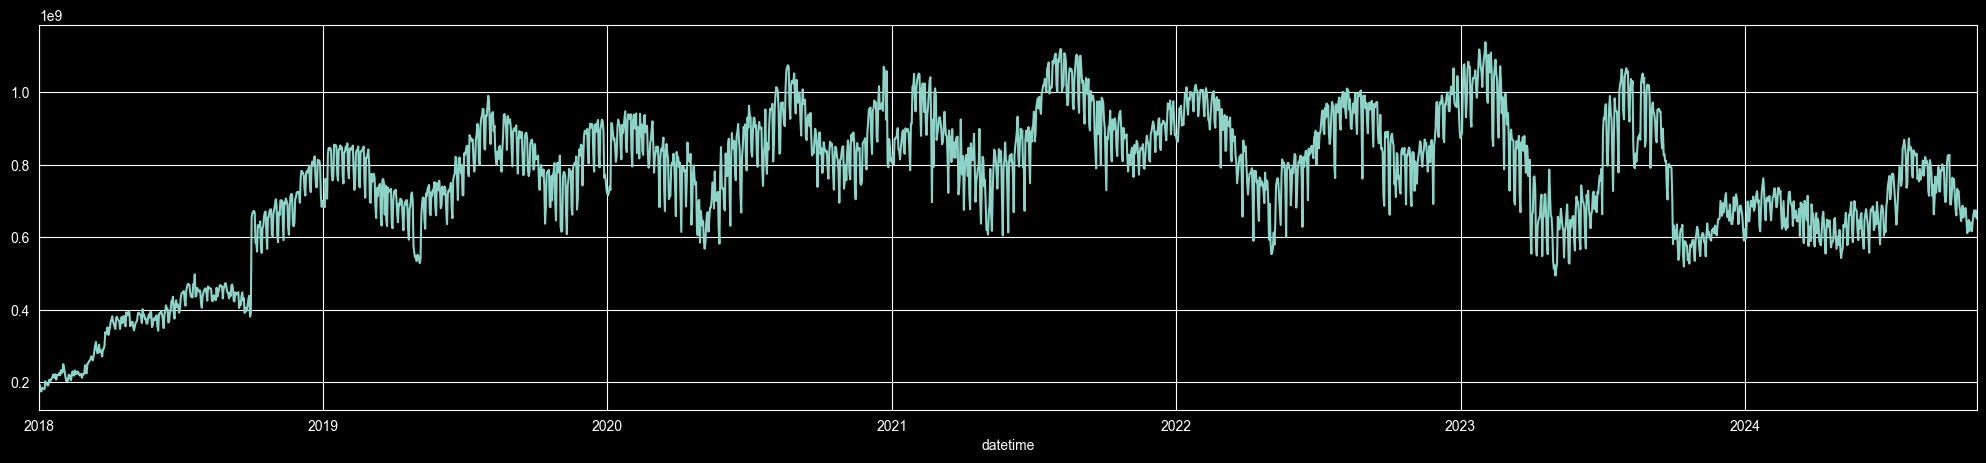

In [5]:
jpn_spot['Contracted Volume kWh'].loc['2018':].resample('D').sum().plot(figsize=(25,5))

### Fuel Mix

Text(0.0, 1.0, "Mean temperature across grids (not load weighted) with 'comfortable temperature bands'.\n1.Can see that spring/august are in range. \n2. Am not sure the extent to which temp and irradiance are correlated (for reasons below, when I see solar hour has zero prices even in Jan 2024 winter. Confusing)")

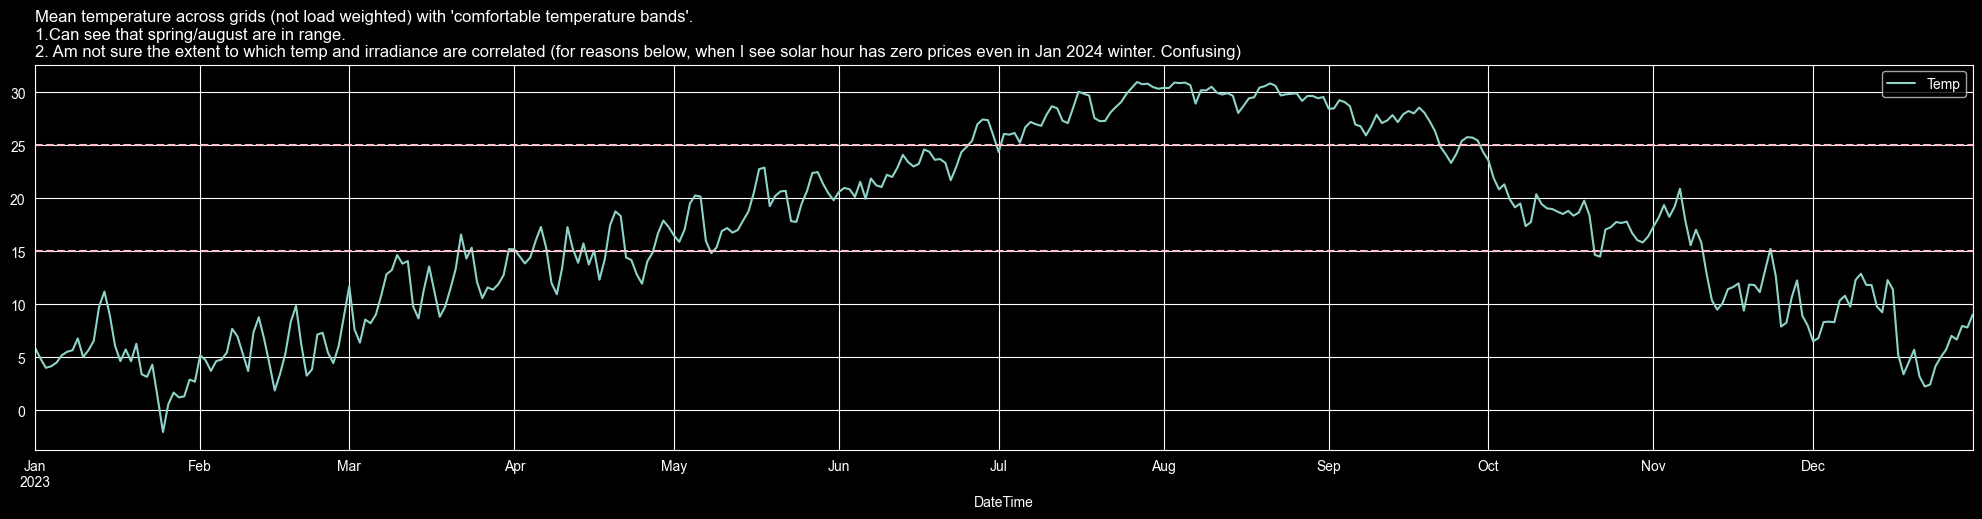

In [43]:
ax = weather.mean(axis=1).to_frame('Temp').loc['2023'].plot(figsize=(25,5))
plt.axhline(15, color='pink', linestyle='--')
plt.axhline(25, color='pink', linestyle='--')

ax.set_title("""Mean temperature across grids (not load weighted) with 'comfortable temperature bands'.\n1.Can see that spring/august are in range. \n2. Am not sure the extent to which temp and irradiance are correlated (for reasons below, when I see solar hour has zero prices even in Jan 2024 winter. Confusing)""", loc='left')

Text(0.0, 1.0, "Thermal power generation (Mw) across Japan, scraped fuel mix data from renewables-ei.org API. \n1. Seems correlated with mean weather outside of comfortable temp band: in winter (Jan, Feb), guess that demand comes from electric heating/heat pumps (outside of gas-based space heating), increased lighting (less sunlight) \n 2. But in summer (Jun-Aug), thermal gen increases as people need air-conditioning. From load chart above, total generation is always higher in summer than winter. Is this because can't use gas for air-con? \n 3. Peak thermal generation is higher for winter than summer. Is this due to lack of solar/hydro in winter?")

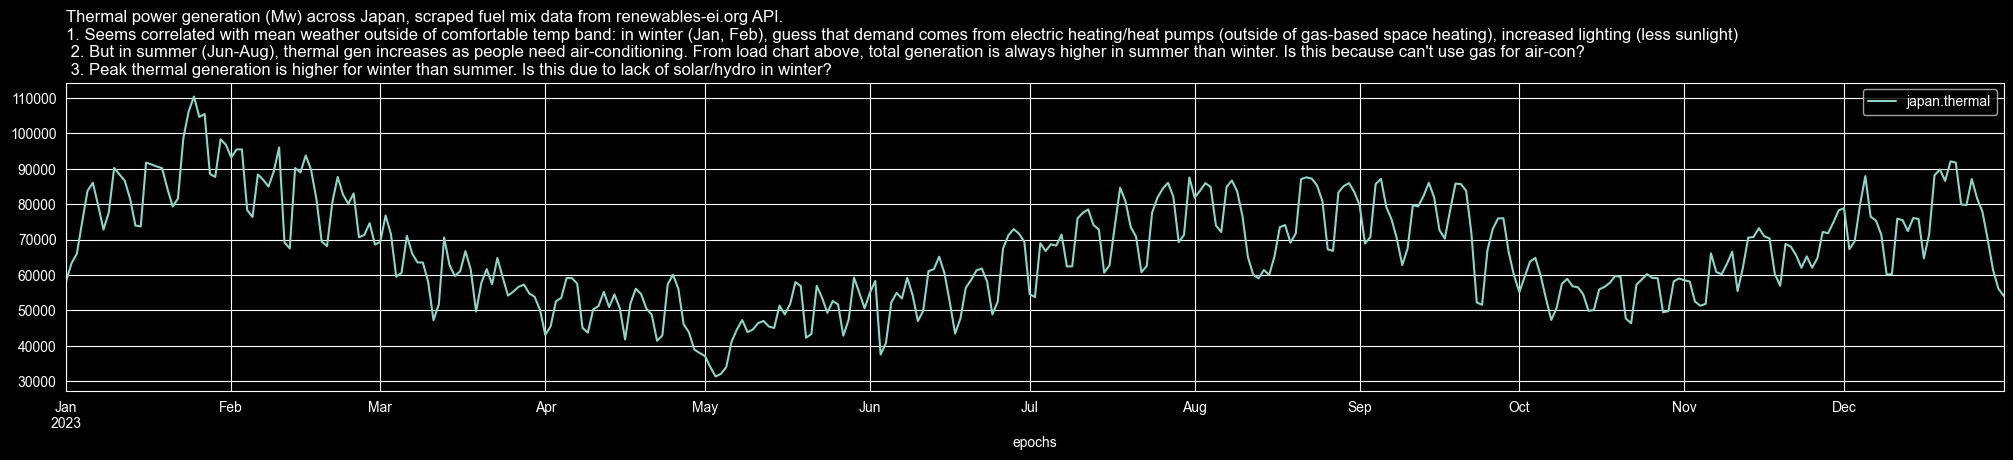

In [26]:
ax = jpn_mix[['japan.thermal']].loc['2023'].resample("1D").mean().plot(figsize=(25,4))
ax.set_title("""Thermal power generation (Mw) across Japan, scraped fuel mix data from renewables-ei.org API. \n1. Seems correlated with mean weather outside of comfortable temp band: in winter (Jan, Feb), guess that demand comes from electric heating/heat pumps (outside of gas-based space heating), increased lighting (less sunlight) \n 2. But in summer (Jun-Aug), thermal gen increases as people need air-conditioning. From load chart above, total generation is always higher in summer than winter. Is this because can't use gas for air-con? \n 3. Peak thermal generation is higher for winter than summer. Is this due to lack of solar/hydro in winter?""", loc='left')

Text(0.0, 1.0, 'Renewable power generation (Mw) across Japan. Took fuel mix data from renewables-ei.org API. \n 1. Solar generation seems to ramp up in spring/summer which is explainable. \n 2. Hydro has 3 columns in the dataset, hydro, pump up, pump down.\n3. First hydro (excluding pumped) correlated to solar (seasonal) river flows, so traditional? More river flow in Spring? Melting snow?')

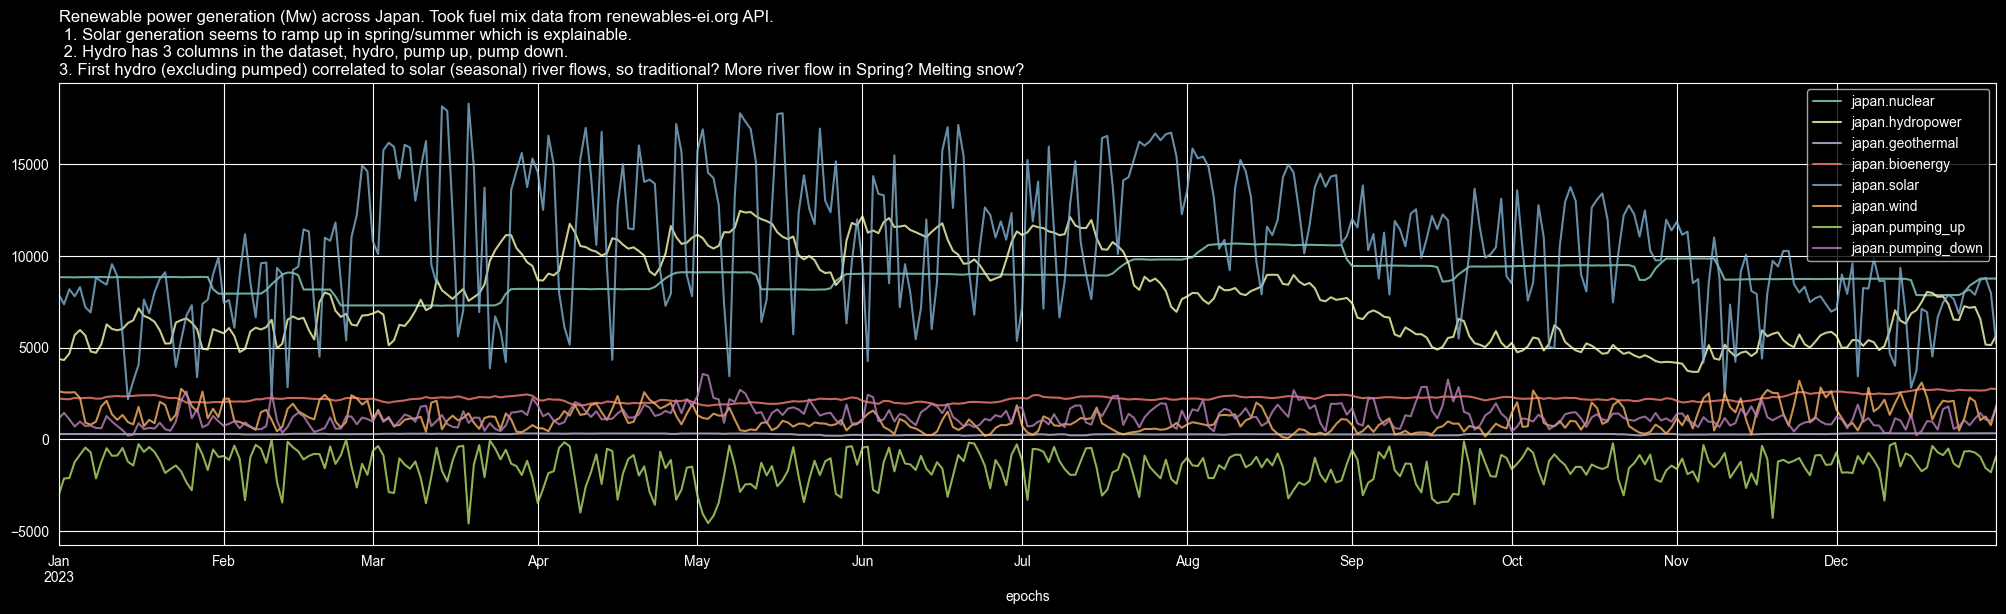

In [52]:
ax = jpn_mix[['japan.nuclear','japan.hydropower','japan.geothermal','japan.bioenergy','japan.solar','japan.wind', 'japan.pumping_up','japan.pumping_down']].loc['2023'].resample('1D').mean().plot(figsize=(25,6),alpha=0.8)

ax.set_title("""Renewable power generation (Mw) across Japan. Took fuel mix data from renewables-ei.org API. \n 1. Solar generation seems to ramp up in spring/summer which is explainable. \n 2. Hydro has 3 columns in the dataset, hydro, pump up, pump down.\n3. First hydro (excluding pumped) correlated to solar (seasonal) river flows, so traditional? More river flow in Spring? Melting snow?""", loc='left')

### Day Ahead Dispersion

I read https://gemenergyanalytics.substack.com/p/where-are-the-cheap-and-the-expensive Julien Jomaux's substack analysis on European day ahead power prices in 2024 and wanted to replicate the analysis on Japanese data as a project. 

He shows the effect of solar cannibalisation in EU countries with high solar penetration at a seasonal and intraday period: in winter months, dispersion between 14z and 20z is low, but in summer (May-Jul), dispersion increases: solar hour gets cheap and peak hour gets more expensive.

He writes this is the effect of high solar penetration (e.g Germany). I read Japan goverment has been heavily trying to increase solar/wind penetration via policy, so wanted to see if the same effects happened in Japan.

From charts below, on a seasonal basis, this effect is much less pronounced but visible (Probably the very warm winter in Japan in 2023?). But can clearly see this effect happen on a daily basis (more 0 prices in Spring)

In [28]:
disp = (
    pl.from_pandas(jpn_spot)
        .with_columns(
            pl.col('Date').str.to_datetime('%Y-%m-%d')
            )
        .filter(
            # pl.col('PeriodID').is_in([24, 38]),
            pl.col('Date').dt.year()==2023,
        )
        .select(
            pl.col('Date'),
            pl.col('PeriodID'),
            pl.col('System Price Yen/kWh')
        )
        .pivot(
            on='PeriodID',
            index='Date'
        )
        # .select(
        #     pl.col('Date'), pl.col('Solar Hours'), pl.col('Peak Hours')
        # )

).to_pandas().set_index('Date')

disp['Solar'] = disp.loc[:, '22':'28'].mean(axis=1)
disp['Peak'] = disp.loc[:, '36':'40'].mean(axis=1)
disp['Spread'] = disp['Peak'] - disp['Solar']

Text(0.0, 1.0, 'Spread between solar and peak day ahead prices in 2023 \n1. Looks like opposite effect: spread declines during summer months. \n2. Suspect could be because winter (temp) and irradiance not as negatively correlated, aka sunny winters. Hence seeing some zero prices in solar hours in Jan 2023. \n3. I am curious as to why.')

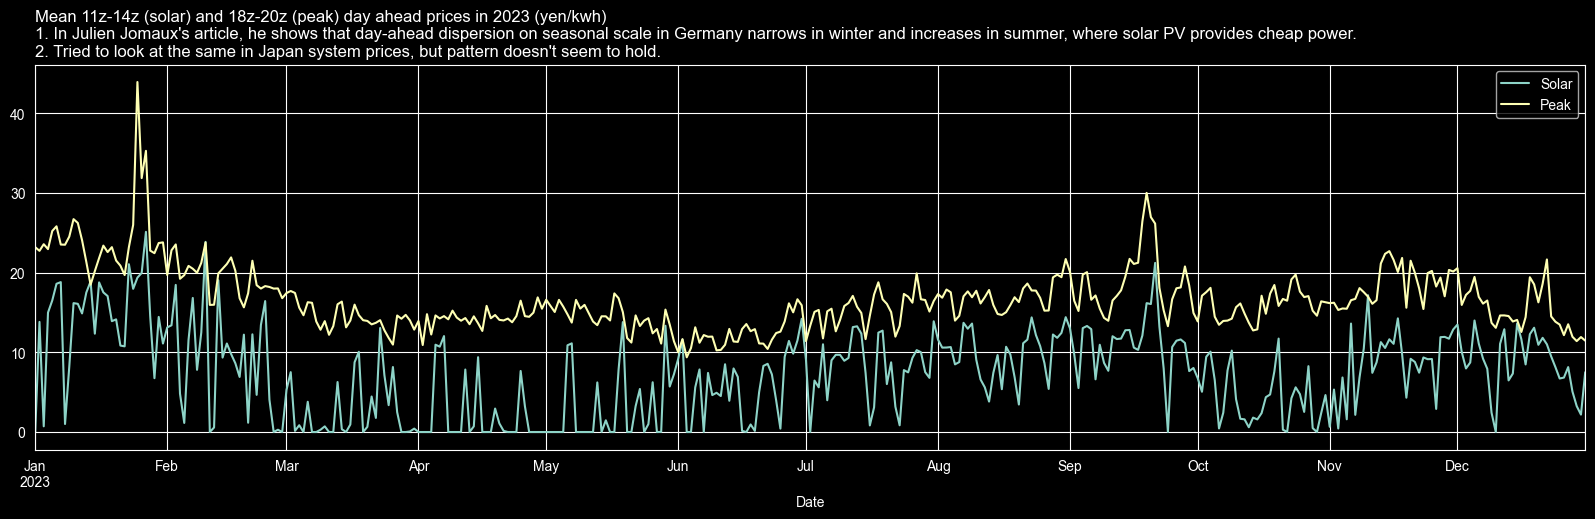

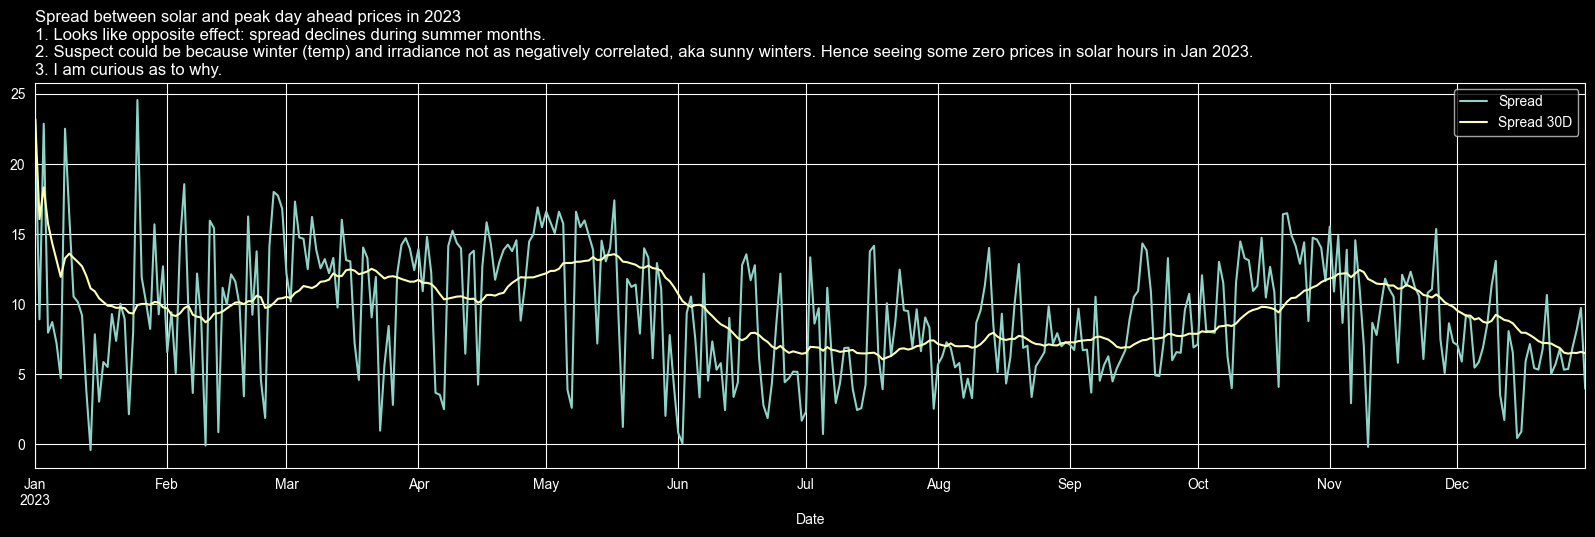

In [29]:
ax = disp[['Solar','Peak']].plot(figsize=(20,5))
ax.set_title("""Mean 11z-14z (solar) and 18z-20z (peak) day ahead prices in 2023 (yen/kwh) \n1. In Julien Jomaux's article, he shows that day-ahead dispersion on seasonal scale in Germany narrows in winter and increases in summer, where solar PV provides cheap power. \n2. Tried to look at the same in Japan system prices, but pattern doesn't seem to hold.""", loc='left')



disp['Spread 30D'] = disp['Spread'].rolling('30D').mean()

ax = disp[['Spread','Spread 30D']].plot(figsize=(20,5))
ax.set_title("""Spread between solar and peak day ahead prices in 2023 \n1. Looks like opposite effect: spread declines during summer months. \n2. Suspect could be because winter (temp) and irradiance not as negatively correlated, aka sunny winters. Hence seeing some zero prices in solar hours in Jan 2023. \n3. I am curious as to why.""", loc='left')


### Duck Curve 
 

<Axes: xlabel='H'>

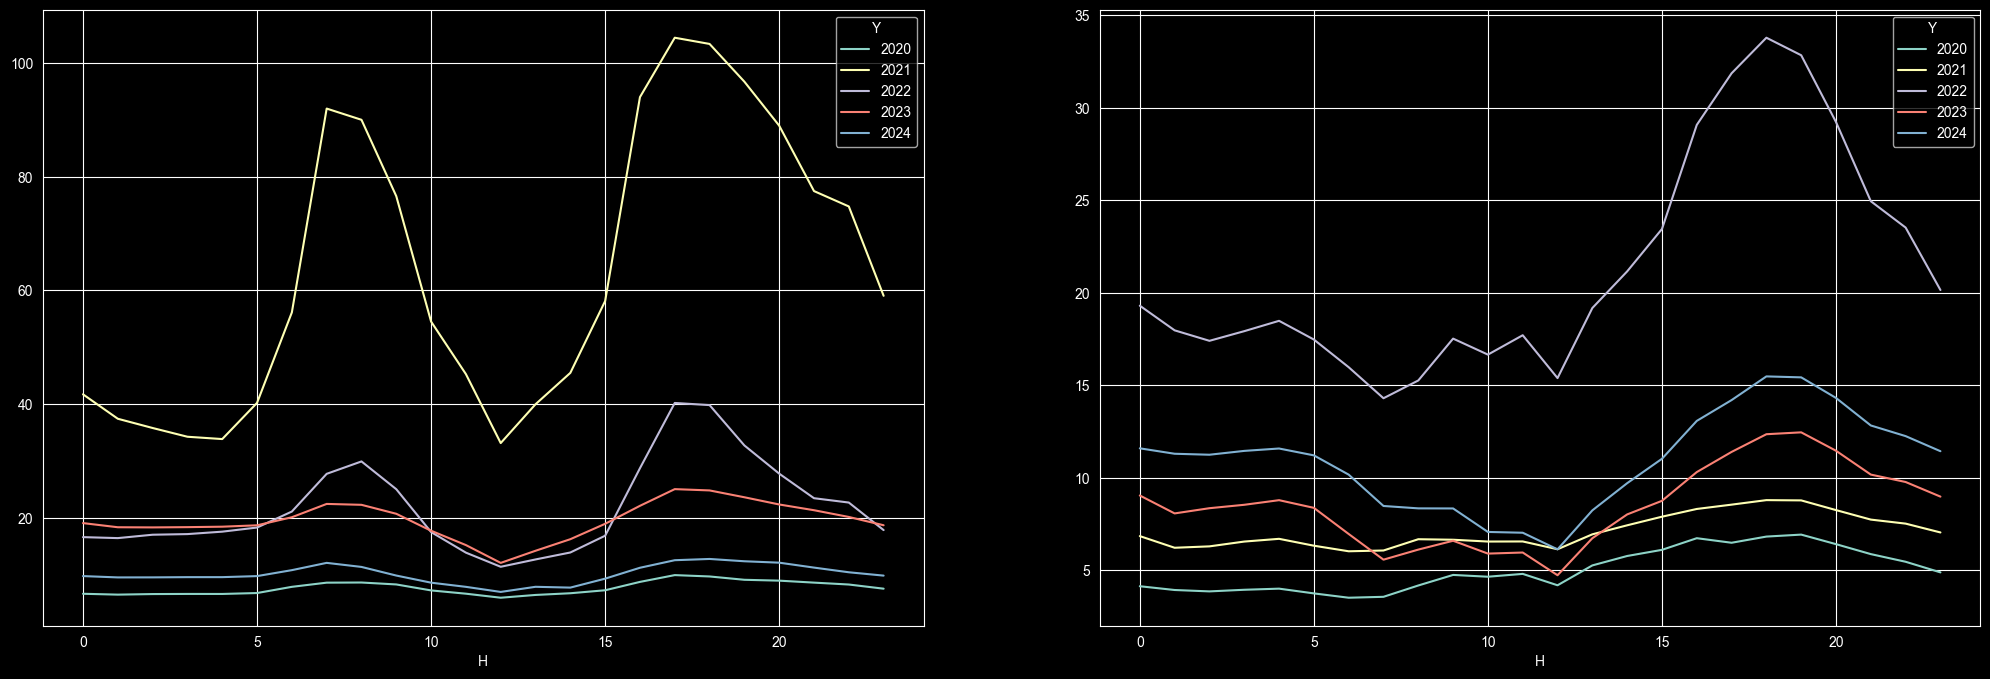

In [140]:
import warnings
warnings.filterwarnings("ignore")

system = jpn_spot[['System Price Yen/kWh']].loc['2020':]

system['Y'] = system.index.year
system['H'] = system.index.hour
system['M'] = system.index.month


june_duck = system[system.M==6].pivot_table(values='System Price Yen/kWh', index='H', columns='Y', aggfunc='mean')
jan_duck = system[system.M==1].pivot_table(values='System Price Yen/kWh', index='H', columns='Y', aggfunc='mean')


fig, ax = plt.subplots(1,2,figsize=(25,8))

jan_duck.plot(ax=ax[0])
june_duck.plot(ax=ax[1])

## AUS


### Prices & Demand

* Taking a look at some prices & demand get a feel for the numbers.
* Notice that Australian prices 'feels' more volatile & messier than Japanese prices. Market structure? Natural factors? More solar?

In [2]:
aus_mix = pd.read_csv("NEM Fuel Mix (1W, 2023-2024).csv")
aus_mix.index = pd.to_datetime(aus_mix.DateTime)
aus_mix = aus_mix.pivot(columns=['State','Fuel Type'], values='Supply')

C:\Users\Ryan\AppData\Local\Temp\ipykernel_8548\1176747309.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  aus_mix.index = pd.to_datetime(aus_mix.DateTime)


In [3]:
aus_spot = pl.read_parquet('NEM_Spot.parquet')[:,:4]

aus_spot = aus_spot.group_by_dynamic(
    index_column="SETTLEMENTDATE",   # The datetime column to resample
    every="1h",                      # Resample to hourly intervals
    closed="right",                  # Use right-closed intervals
    by="REGION"                      # Group by REGION before resampling
).agg([
    pl.col("RRP").mean().alias("mean_RRP"),           # Mean of RPP for each hour
    pl.col("TOTALDEMAND").sum().alias("sum_TOTALDEMAND")  # Sum of TOTALDEMAND for each hour
])

aus_spot = aus_spot.to_pandas().set_index('SETTLEMENTDATE').pivot(columns='REGION')


C:\Users\Ryan\AppData\Local\Temp\ipykernel_8548\3323468157.py:3: DeprecationWarning: The argument `by` for `DataFrame.group_by_dynamic` is deprecated. It has been renamed to `group_by`.
  aus_spot = aus_spot.group_by_dynamic(


Text(0.0, 1.0, 'Mean daily demand mWh 2022-present \nDemand picture looks normal. So must be supply side causing increased volatility')

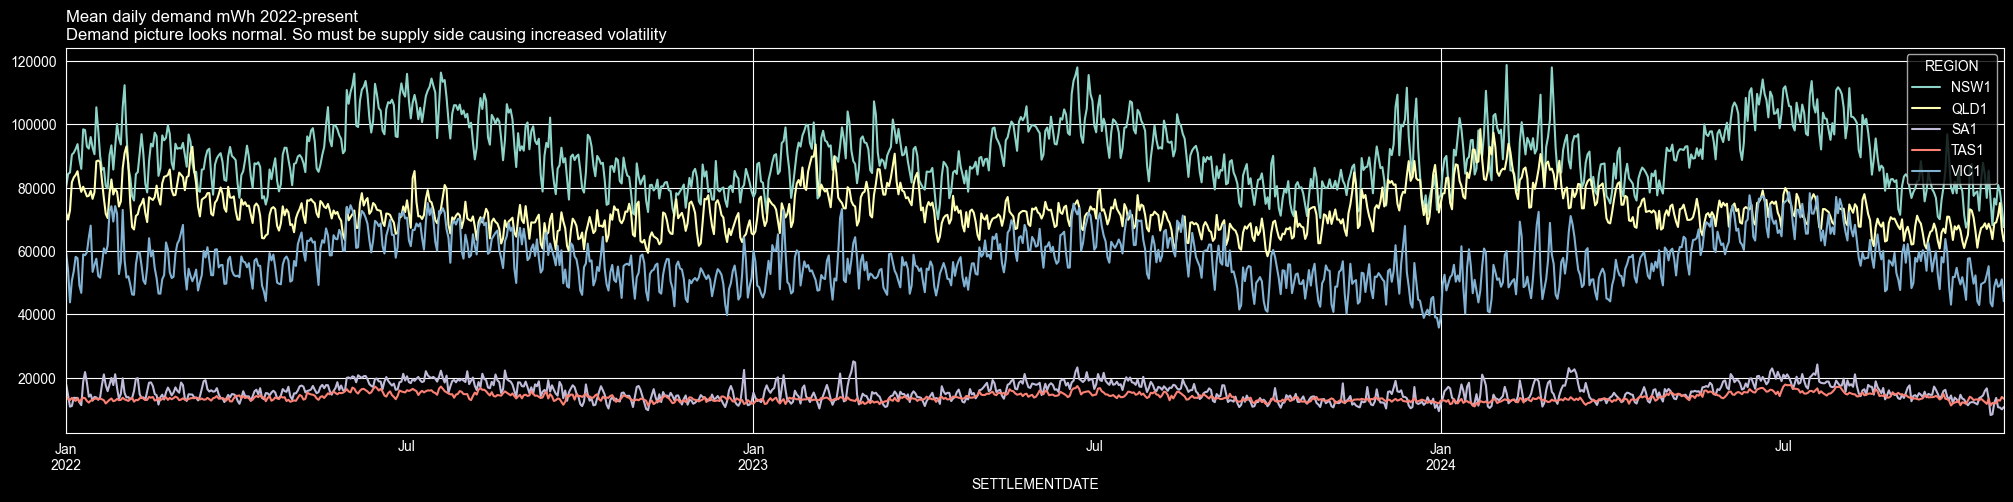

In [226]:
ax = aus_spot['sum_TOTALDEMAND'].loc['2022':].resample('1D').mean().plot(figsize=(25,5))
ax.set_title("""Mean daily demand mWh 2022-present \nDemand picture looks normal. So must be supply side causing increased volatility""",loc='left')

Text(0.0, 1.0, 'Median prices daily (not demand-weighted) from AEMO API')

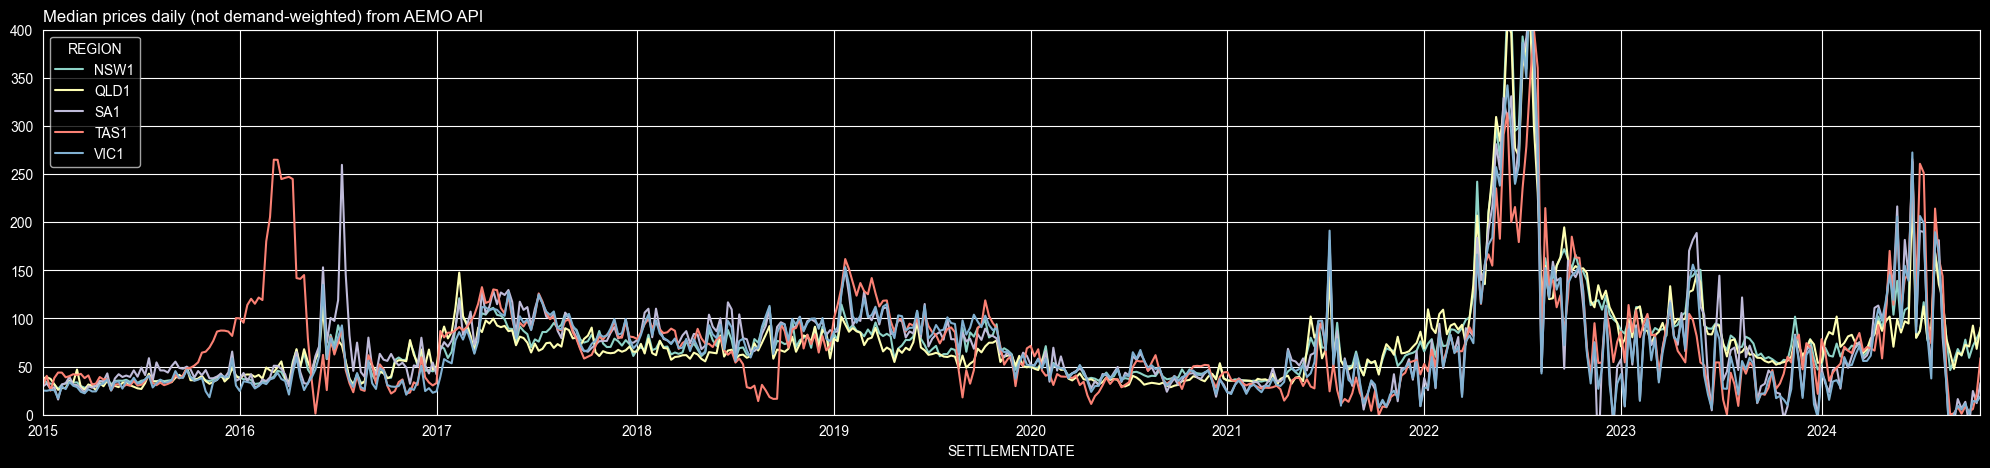

In [176]:
ax = aus_spot['mean_RRP'].resample('1W').median().plot(figsize=(25,5),ylim=(0,400))

ax.set_title("""Median prices daily (not demand-weighted) from AEMO API""",loc='left')

Text(0.0, 1.0, 'Median prices daily (not demand-weighted) from AEMO API\n1. Volatility and prices have gone up within recent years. Excluding 2022, why 2023/2024?')

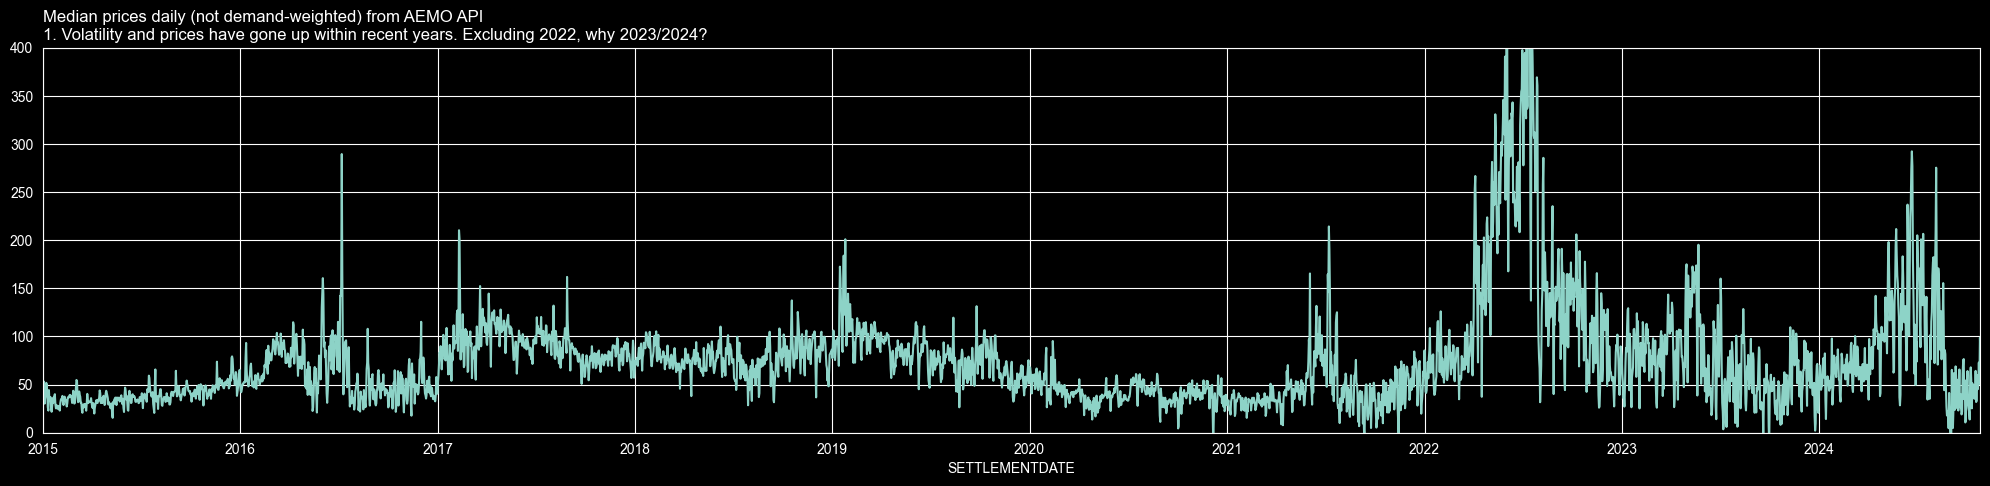

In [180]:
ax = aus_spot['mean_RRP'].mean(axis=1).resample('1D').median().plot(figsize=(25,5),ylim=(0,400))

ax.set_title("""Median prices daily (not demand-weighted) from AEMO API\n1. Volatility and prices have gone up within recent years. Excluding 2022, why 2023/2024?""",loc='left')

Text(0.0, 1.0, 'Min prices daily (not demand-weighted) from AEMO API\n1. Lots of extreme negative prices due to high solar penetration?')

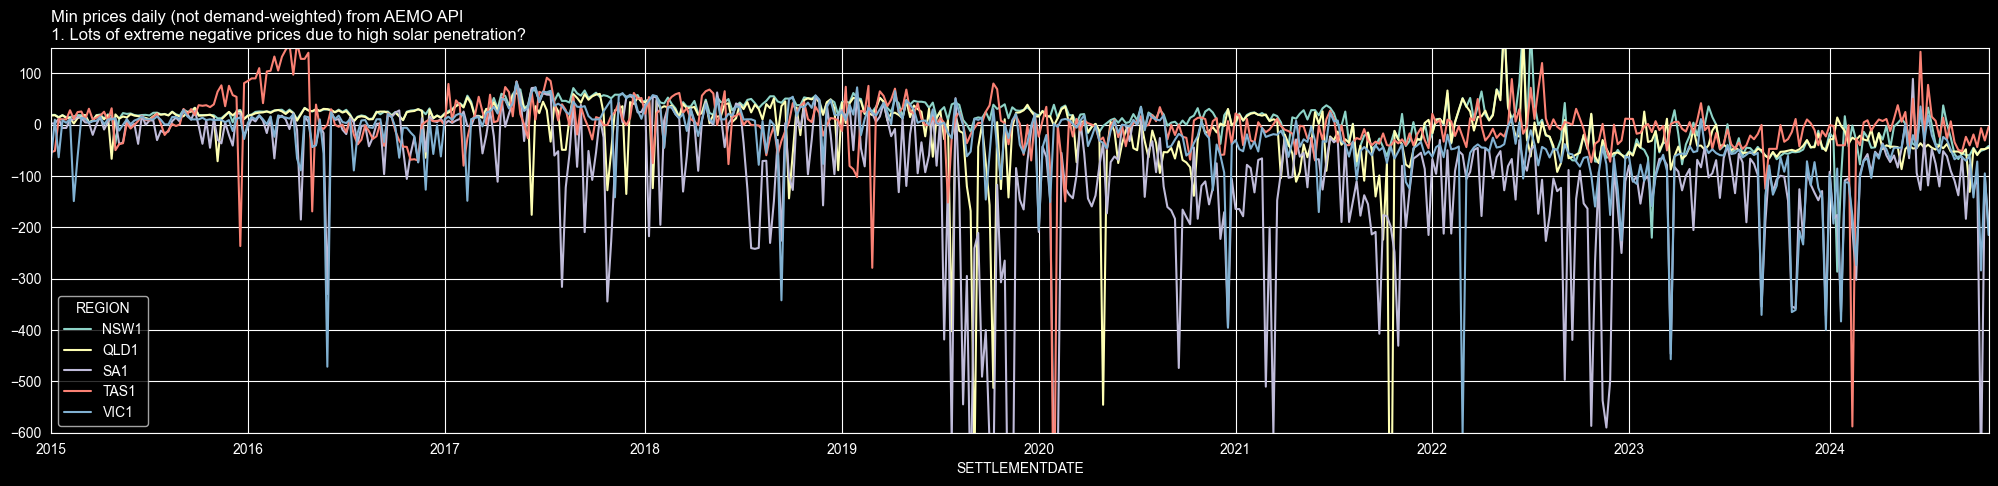

In [232]:
ax = aus_spot['mean_RRP'].resample('1W').min().plot(figsize=(25,5),ylim=(-600,150))

ax.set_title("""Min prices daily (not demand-weighted) from AEMO API\n1. Lots of extreme negative prices due to high solar penetration?""",loc='left')

In [17]:
comparison = pd.DataFrame()
comparison['jpn_converted'] = jpn_spot.loc['2018':,'System Price Yen/kWh'].resample('D').median() * 1e3 / 101.38
comparison['aus_converted'] = aus_spot['mean_RRP'].loc['2018':,'NSW1'].resample('D').median().iloc[:-1]

<Axes: title={'center': 'Daily median Japanese system price vs daily median NSW price, AUD/mWh equivalent, not demand weighted, 2024'}, xlabel='datetime'>

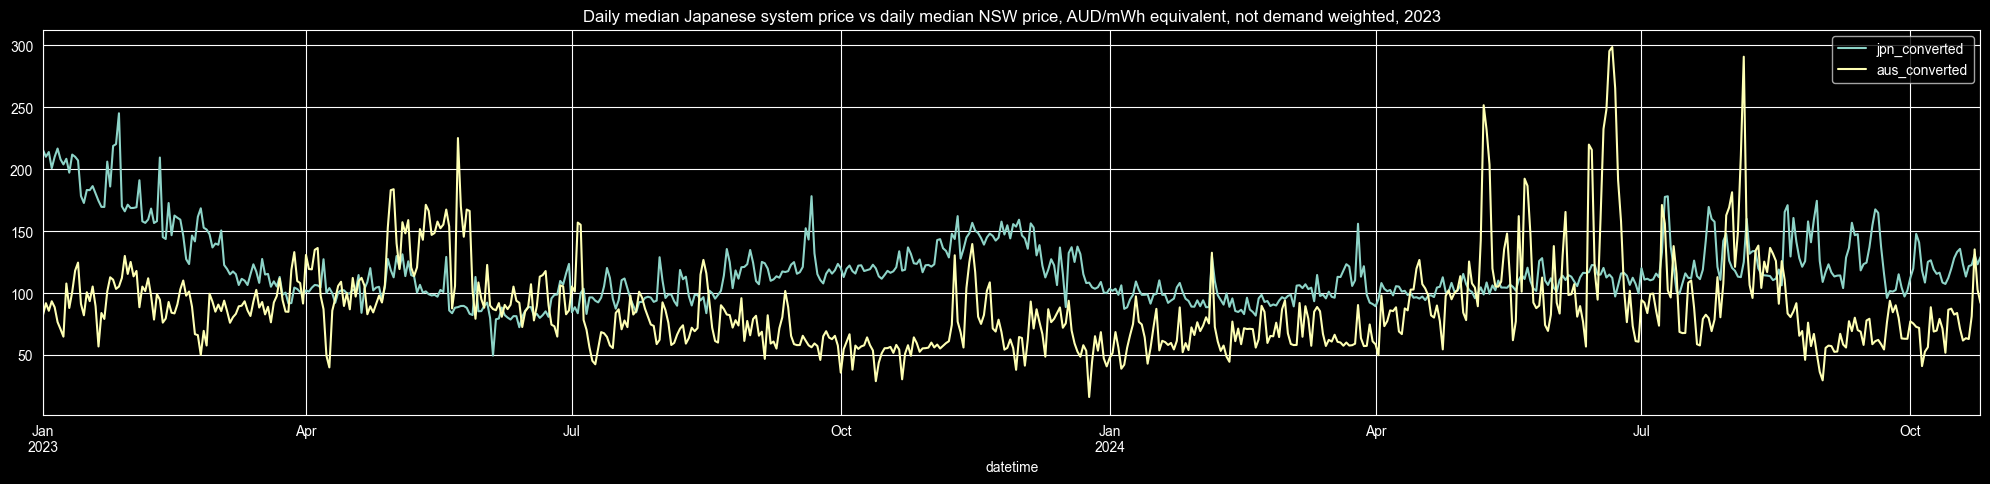

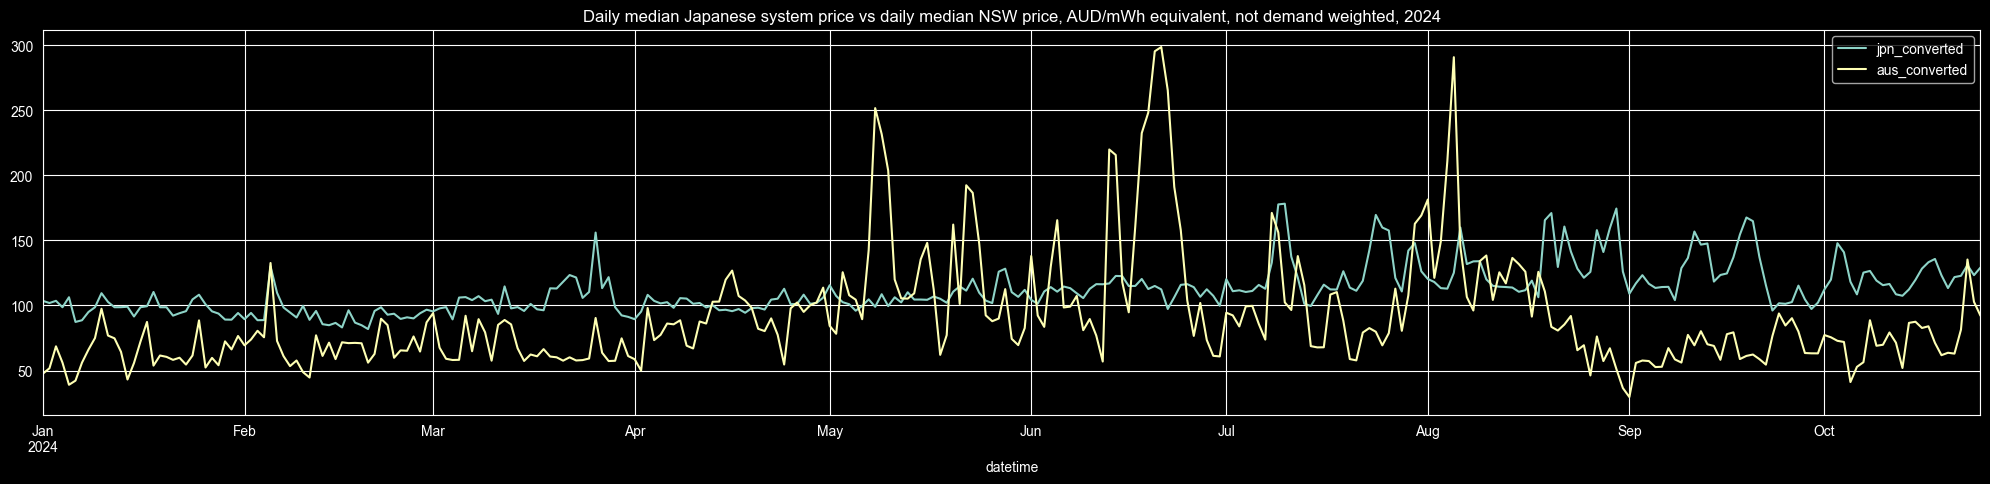

In [25]:
comparison.loc['2023':].plot(figsize=(25,5),title='Daily median Japanese system price vs daily median NSW price, AUD/mWh equivalent, not demand weighted, 2023')
comparison.loc['2024':].plot(figsize=(25,5),title='Daily median Japanese system price vs daily median NSW price, AUD/mWh equivalent, not demand weighted, 2024')